In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import nltk
from scipy import sparse
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    learning_curve, StratifiedShuffleSplit, cross_val_score, ShuffleSplit,
    cross_val_predict, RandomizedSearchCV
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import nltk

# Set figure display options
%matplotlib inline
#sns.set(context='notebook', style='darkgrid')
#sns.set(font_scale=1.3)

**Loading Final Dataset**

In [2]:
from sklearn.externals import joblib

#Loading the dataset
df_full = joblib.load('/Users/shwetapai/Desktop/final_full_dataset.pkl')

In [3]:
features=['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
       'num_exclms', 'percent_exclms', 'num_imp_words', 'percent_imp_words',
       'avg_words_per_sent', 'num_paragraphs', 'avg_sents_per_paragraph',
       'avg_words_per_paragraph', 'num_images', 'num_videos', 'num_youtubes',
       'num_hyperlinks', 'num_bolded', 'percent_bolded','sentiment']

#making a dataset with only features listed above

X = df_full[features]
X.head()

,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_imp_words,percent_imp_words,avg_words_per_sent,num_paragraphs,avg_sents_per_paragraph,avg_words_per_paragraph,num_images,num_videos,num_youtubes,num_hyperlinks,num_bolded,percent_bolded,sentiment
0,54.0,1147.0,2.0,0.001744,2.0,0.001744,1.0,0.000872,21.240741,28.0,2.428571,40.392857,2.0,1.0,0.0,0.0,0.0,0.000000,0.9986
1,63.0,1051.0,10.0,0.009515,4.0,0.003806,0.0,0.000000,16.682540,42.0,1.857143,25.357143,4.0,0.0,0.0,4.0,0.0,0.000000,0.9979
2,136.0,2146.0,16.0,0.007456,1.0,0.000466,0.0,0.000000,15.779412,82.0,2.000000,25.512195,18.0,1.0,3.0,3.0,40.0,0.018639,0.9996
3,77.0,1006.0,13.0,0.012922,7.0,0.006958,0.0,0.000000,13.064935,47.0,1.595745,20.638298,34.0,11.0,0.0,0.0,0.0,0.000000,0.9992
4,29.0,636.0,3.0,0.004717,1.0,0.001572,0.0,0.000000,21.931034,10.0,3.100000,62.600000,2.0,0.0,0.0,1.0,0.0,0.000000,0.9861


**Loading helper Functions**

In [4]:
#creating n-grams for 'normalized text'section after preprocessing the section
import re
import unicodedata
from sklearn.feature_extraction import text 

import re
import unicodedata

def remove_punc(text):
    """Remove all punctuation from the text of a campaign section
    
    Args:
        text (str): cleaned and normalized text of a campaign section
    
    Returns:
        a string containing the text of a campaign section without any
        punctuation"""
    
    # Remove punctuation with regex
    return re.sub(r'[^\w\d\s]|\_', ' ', text)


def preprocess_text(text):
    """Perform text preprocessing such as removing punctuation, lowercasing all
    words, removing stop words and stemming remaining words
    
    Args:
        text (str): cleaned and normalized text of a campaign section
    
    Returns:
        a string containing text that has been preprocessed"""
    
    # Access stop word dictionary
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Prepare the Porter stemmer
    porter = nltk.PorterStemmer()
    
    # Remove punctuation and lowercase each word
    text = remove_punc(text).lower()
    
    # Remove stop words and stem each word
    return ' '.join(
        porter.stem(term )
        for term in text.split()
        if term not in stop_words
    )


**Data Preparation**

In [5]:

#preprocessing the 'normalized text section'

preprocessed_text = df_full.loc[X.index, 'normalized_text'].apply(preprocess_text)


#use vectorizer on the preprocessed text
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=250)


X_ngrams = vectorizer.fit_transform(preprocessed_text)
X_ngrams

#try using nmf sparse
from sklearn.decomposition import NMF

no_topics = 20

# Run NMF
nmf=NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_matrix = nmf.fit_transform(X_ngrams)


In [6]:
tfidf_feature_names = vectorizer.get_feature_names()


In [7]:
#Convert the meta features into a sparse matrix
X_sparse = sparse.csr_matrix(X)

# Concatenate the meta features with the n-grams
X_full = sparse.hstack([X_sparse, nmf_matrix])

# Display the shape of the combined matrix for confirmation
X_full.shape

(5802, 39)

In [8]:
X_full_dense=X_full.todense()

In [9]:
scaler = StandardScaler()
X_full_std = scaler.fit_transform(X_full_dense)

**Target Variable**

In [10]:
# Prepare the classification target variable
y = df_full.loc[X.index, 'funded'].to_frame()

In [11]:
# Display the class distribution
y['funded'].value_counts()

True     3186
False    2616
Name: funded, dtype: int64

In [12]:
# Encode the class labels in the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

**Splitting the Dataset**

In [13]:
#Splitting the dataset into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full_std, y_enc, test_size=0.25, random_state=42)

**FITTING THE FINAL MODEL (RANDOM FOREST CLASSIFIER)**

In [14]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

**Finding the Most Predictive Features**

In [15]:
best_rf = joblib.load('/Users/shwetapai/Desktop/final_rfc.pkl')

In [16]:
X_features=best_rf.feature_importances_

In [17]:
X_features

array([0.00883208, 0.02062864, 0.00551575, 0.01014439, 0.01435878,
       0.06114681, 0.00049039, 0.00314399, 0.01068878, 0.02850341,
       0.01775259, 0.01277335, 0.02825791, 0.00046163, 0.00039397,
       0.11786784, 0.00414793, 0.0139676 , 0.01798431, 0.0090912 ,
       0.06855452, 0.02770774, 0.01573982, 0.08139455, 0.09258796,
       0.09379063, 0.01436877, 0.01003944, 0.00396014, 0.00684938,
       0.08246895, 0.04113146, 0.00321651, 0.01120803, 0.01202655,
       0.01266044, 0.01805385, 0.00782622, 0.01026369])

In [18]:
X_features_list=list(X_features)
len(X_features_list)

39

In [19]:
X.columns

Index(['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
       'num_exclms', 'percent_exclms', 'num_imp_words', 'percent_imp_words',
       'avg_words_per_sent', 'num_paragraphs', 'avg_sents_per_paragraph',
       'avg_words_per_paragraph', 'num_images', 'num_videos', 'num_youtubes',
       'num_hyperlinks', 'num_bolded', 'percent_bolded', 'sentiment'],
      dtype='object')

In [20]:
columns=['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
       'num_exclms', 'percent_exclms', 'num_imp_words', 'percent_imp_words',
       'avg_words_per_sent', 'num_paragraphs', 'avg_sents_per_paragraph','avg_words_per_paragraph',
        'num_images', 'num_videos', 'num_youtubes','num_hyperlinks', 
         'num_bolded', 'percent_bolded','percent_bolded','topic1',
         'Funding Related','topic3','topic4','Design Related',
         'topic6','tech related','Pledge Related','topic9',
         'topic10','topic11','topic12','User Related',
         'topic14','topic15','topic16','topic17',
         'topic18','topic19','topic20']
len(columns)

39

**DataFrame with all the Features and their Predictive Score**

In [21]:
list_name=columns
list_coeff=X_features_list
df_list = pd.DataFrame(
    {'Feature': list_name,
     'Score': list_coeff
    })

df_list=df_list.sort_values(['Score'], ascending=[True])
df_list

,Feature,Score
14,num_youtubes,0.000394
13,num_videos,0.000462
6,num_imp_words,0.000490
7,percent_imp_words,0.003144
32,topic14,0.003217
28,topic10,0.003960
16,num_bolded,0.004148
2,num_all_caps,0.005516
29,topic11,0.006849
37,topic19,0.007826


**Graph of All Features with their Predictive Score**

Text(0.5,0,'Score')

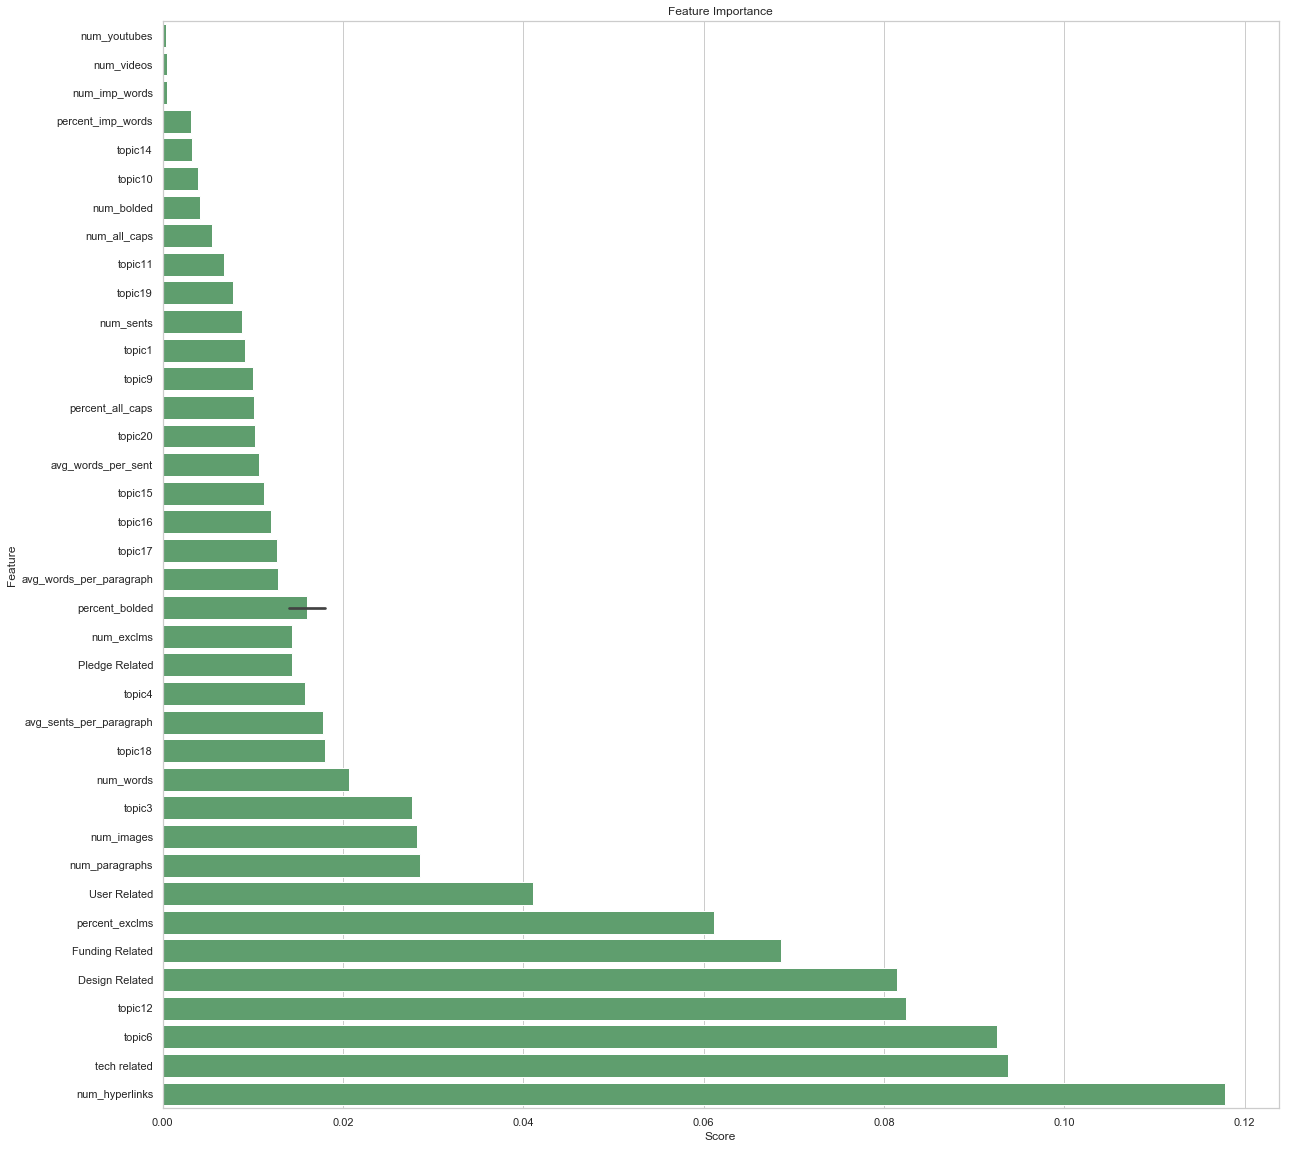

In [22]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20,20))

ax = sns.barplot(x='Score', y='Feature', data=df_list,color='g')
ax.set_title('Feature Importance')
ax.set_xlabel('Score')

**Most predictive Features**

In [23]:
predictive_features=[columns[26],columns[25],columns[20],columns[15],columns[5],columns[9]]
names=['Pledge Related','Tech related','Funding Related','num_hyperlinks','%exclams','num_paragraphs']

In [25]:
predictive_features

['Pledge Related',
 'tech related',
 'Funding Related',
 'num_hyperlinks',
 'percent_exclms',
 'num_paragraphs']

**Helper Functions**

In [26]:
import re
import unicodedata
import requests

import re
import unicodedata

def remove_punc(text):
    """Remove all punctuation from the text of a campaign section
    
    Args:
        text (str): cleaned and normalized text of a campaign section
    
    Returns:
        a string containing the text of a campaign section without any
        punctuation"""
    
    # Remove punctuation with regex
    return re.sub(r'[^\w\d\s]|\_', ' ', text)


def preprocess_text(text):
    """Perform text preprocessing such as removing punctuation, lowercasing all
    words, removing stop words and stemming remaining words
    
    Args:
        text (str): cleaned and normalized text of a campaign section
    
    Returns:
        a string containing text that has been preprocessed"""
    
    # Access stop word dictionary
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Prepare the Porter stemmer
    porter = nltk.PorterStemmer()
    
    # Remove punctuation and lowercase each word
    text = remove_punc(text).lower()
    
    # Remove stop words and stem each word
    return ' '.join(
        porter.stem(term )
        for term in text.split()
        if term not in stop_words
    )

In [27]:
def scrape(hyperlink):
    """Use the Requests library to scrape a Kickstarter project page
    
    Args:
        hyperlink (str): URL of the Kickstarter page to scrape
    
    Returns:
        a response object containing the scraped content"""
    
    return requests.get(hyperlink)

def parse(scraped_html):
    """Use the BeautifulSoup library to parse the scraped HTML of a project 
    using an lxml parser
    
    Args:
        scraped_html (response object): the unparsed response object collected
        by the web scraper
    
    Returns:
        a soup object containing the parsed HTML"""
    
    # Parse the HTML content using an lxml parser
    return BeautifulSoup(scraped_html.text, 'lxml')

def cleaning(text):    
    
    # Remove line breaks, leading and trailing whitespace, and compress all
    # whitespace to a single space
    text_cleaned = ' '.join(text.split()).strip()
    
    # Remove the HTML5 warning for videos
    return text_cleaned.replace("You'll need an HTML5 capable browser to see this content. " + \
        "Play Replay with sound Play with sound 00:00 00:00",' ')




In [28]:
def campaign_details(soup):
    
    # Collect the "About this project" section if available
    try:
        section1 = soup.find(
            'div',
            class_='full-description js-full-description responsive-media ' + \
                'formatted-lists'
        ).get_text(' ')
    except AttributeError:
        section1 = 'section_not_found'
    
    # Collect the "Risks and challenges" section if available, and remove all
    # unnecessary text
    try:
        section2 = soup.find(
            'div', 
            class_='mb3 mb10-sm mb3 js-risks'
        ) \
            .get_text(' ') \
            .replace('Risks and challenges',' ') \
            .replace('Learn about accountability on Kickstarter',' ')
    except AttributeError:
        section2 = 'section_not_found'
    
    # Clean both campaign sections
    return {'about': cleaning(section1), 'risks': cleaning(section2)}

def normalize(text):
    
    # Tag email addresses with regex
    normalized = re.sub(
        r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
        'emailaddr',
        text
    )
    
    # Tag hyperlinks with regex
    normalized = re.sub(
        r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
        'httpaddr',
        normalized
    )
    
    # Tag money amounts with regex
    normalized = re.sub(r'\$\d+(\.\d+)?', 'dollramt', normalized)
    
    # Tag percentages with regex
    normalized = re.sub(r'\d+(\.\d+)?\%', 'percntg', normalized)
    
    # Tag phone numbers with regex
    normalized = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr',
        normalized
    )
    
    # Tag remaining numbers with regex
    return re.sub(r'\d+(\.\d+)?', 'numbr', normalized)


In [29]:
def sentences_token(text):
     # Tokenize the text into sentences
    return nltk.sent_tokenize(text)


def punc_cleaning(text):
 
    # Remove punctuation with regex
    return re.sub(r'[^\w\d\s]|\_', ' ', text)


def words_token(text):
    
    # Remove punctuation and then tokenize the text into words
    return [word for word in nltk.word_tokenize(punc_cleaning(text))]


def search_allcaps(text):
        
    # Identify all-caps words with regex
    return re.findall(r'\b[A-Z]{2,}', text)


def exclamations_count(text):
    
    # Count the number of exclamation marks in the text
    return text.count('!')


def imp_words_count(text):
    imp_words = frozenset(
        ['revolutionary', 'breakthrough', 'beautiful', 'magical', 
        'gorgeous', 'amazing', 'incredible', 'awesome']
    )
    
    # Count total number of Apple words in the text
    return sum(1 for word in words_token(text) if word in imp_words)



def avg_words_count(text):
    
    # Compute the average number of words in each sentence
    return pd.Series(
        [len(words_token(sentence)) for sentence in sentences_token(text)]
    ).mean()



def paragraphs_count(soup, section):    
    
    # Use tree parsing to count the number of paragraphs depending on which
    # section is requested
    if section == 'about':
        return len(soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('p'))
    elif section == 'risks':
        return len(soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('p'))
    
def avg_sents_paragraph(soup, section):
    #look at 'about' section
    if section == 'about':
        paragraphs = soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('p')
    elif section == 'risks':
        paragraphs = soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('p')
    
    # Compute the average number of sentences in each paragraph    
    return pd.Series(
        [len(sentences_token(paragraph.get_text(' '))) for paragraph in \
         paragraphs]
    ).mean()


def avg_words_paragraph(soup, section):

    # Use tree parsing to identify all paragraphs depending on which section
    # is requested
    if section == 'about':
        paragraphs = soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('p')
    elif section == 'risks':
        paragraphs = soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('p')
    
    # Compute the average number of words in each paragraph
    return pd.Series(
        [len(words_token(paragraph.get_text(' '))) for paragraph in paragraphs]
    ).mean()

def images_count(soup, section):    
    
    # Use tree parsing to identify all image tags depending on which section
    # is requested
    if section == 'about':
        return len(soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('img'))
    elif section == 'risks':
        return len(soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('img'))
    
def videos_count(soup, section):    
    
    # Use tree parsing to count all non-YouTube video tags depending on which
    # section is requested
    if section == 'about':
        return len(soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('div', class_='video-player'))
    elif section == 'risks':
        return len(soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
         ).find_all('div', class_='video-player'))

def youtube_count(soup, section):    
    
    # Initialize total number of YouTube videos
    youtube_count = 0

    # Use tree parsing to identify all iframe tags depending on which section
    # is requested
    if section == 'about':
        iframes = soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
            '-media formatted-lists'
        ).find_all('iframe')
    elif section == 'risks':
        iframes = soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('iframe')
    
    # Since YouTube videos are contained only in iframe tags, determine which
    # iframe tags contain YouTube videos and count them
    for iframe in iframes:
        # Catch any iframes that fail to include a YouTube source link
        try:
            if 'youtube' in iframe.get('src'):
                youtube_count += 1
        except TypeError:
            pass
    
    return youtube_count


def hyperlinks_count(soup, section):    
    """Count the number of hyperlink tags in a campaign section"""
    # Use tree parsing to compute number of hyperlink tags depending on the
    # section requested
    if section == 'about':
        return len(soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('a'))
    elif section == 'risks':
        return len(soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('a'))
    
def count_bold_tags(soup, section):    
    """Count the number of bold tags in a campaign section"""
    
    # Use tree parsing to compute number of bolded text tags depending on which
    # section is requested
    if section == 'about':
        return len(soup.find(
            'div',
            class_='full-description js-full-description responsive' + \
                '-media formatted-lists'
        ).find_all('b'))
    elif section == 'risks':
        return len(soup.find(
            'div',
            class_='mb3 mb10-sm mb3 js-risks'
        ).find_all('b'))

def remove_punc(sentence): 
    #cleanr = re.compile('<.*?>')
    #cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = str(sentence).lower()
    #cleaned = re.sub(r'[?|!|\'|"|#|$|%]',r'',cleantext)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleantext)
    cleaned = str(cleaned).lower()
    
    return cleaned


def preprocess_text(text):
    """Perform text preprocessing such as removing punctuation, lowercasing all
    words, removing stop words and stemming remaining words"""
    
    # Access stop word dictionary
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Initialize the Porter stemmer
    porter = nltk.PorterStemmer()
    
    # Remove punctuation and lowercase each word
    text = remove_punc(text).lower()
    
    # Remove stop words and stem each word
    return ' '.join(
        porter.stem(term )
        for term in text.split()
        if term not in set(stop_words)
    )




In [30]:
def feature_extraction(soup, campaign, section):
    """Extract all the features of the text of campaign section"""
   
    
    # Compute the number of words in the section
    num_words = len(words_token(campaign[section]))
    
    # If the section contains no words, assign NaN to 'num_words' to avoid
    # potential division by zero
    if num_words == 0:
        num_words = np.nan
        
    #If the section isn't available, then return NaN for each meta feature.
    if campaign[section] == 'section_not_found':
        return([np.nan] * 19)
    else:
        return(len(sentences_token(campaign[section])),  #number of the sentence
            num_words,                                # number of words
            len(search_allcaps(campaign[section])), # number of all_caps
            len(search_allcaps(campaign[section])) / num_words,  #% of all caps
            exclamations_count(campaign[section]),              #number of exclamations
            exclamations_count(campaign[section]) / num_words,    #% of exclamations
            imp_words_count(campaign[section]),                   #number of buzz words
            imp_words_count(campaign[section]) / num_words,     #% of buzz words
            avg_words_count(campaign[section]),                #number of avg words
            paragraphs_count(soup, section),                     #number of paragraphs
            avg_sents_paragraph(soup, section),          #number of sentences per paragraph
            avg_words_paragraph(soup, section),          #number of words per paragraph
            images_count(soup, section),                         #number of images
            videos_count(soup, section),                        # number of videos
            youtube_count(soup, section),                       #number of youtube videos
            hyperlinks_count(soup, section),                    #number of hyperlinks
            count_bold_tags(soup, section),                      #number of bold tag
            count_bold_tags(soup, section) / num_words,          #%of bold tags
            sentiment(campaign[section])
        )
        
        
        

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def extract_user_features(hyperlink):

    # Scraping HTML content from hyperlink and  parsing it
    scraped_html = scrape(hyperlink)
    soup = parse(scraped_html)

    # Collecting section 'campaign' and normalize text 
    campaign = campaign_details(soup)
    campaign['about'] = normalize(campaign['about'])
    
    
    # Extract features
    user_features = feature_extraction(soup, campaign, 'about')

    # Preprocessing text in the campaign section
    text_clean = preprocess_text(campaign['about'])
    return user_features, text_clean

def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']

**TESTING**

Predicting Probablity of Success of a User Entered Kickstarter Project

In [32]:

link='https://www.kickstarter.com/projects/rhinocg/rhino-arc-ii-4-axis-robotic-camera-assistant?ref=section-design-tech-featured-project'

In [33]:
import re
from bs4 import BeautifulSoup
# Compute the meta features and preprocess the campaign section
meta_features, processed_section = extract_user_features(link)
#feature_names=('numn_sent','num_words','num_all_caps','%all_caps',
              # 'num_exclam','% exclam','num_imp_words','% imp words',
               #'num_avg_words','num_paragraphs','sent per para',
               #'words per para','num_images','num_videos',
               #'num_youtube_videos','num_hyperlinks','num_bold_tags','%bold_tags')



# Compute the n-grams from the preprocessed text
ngrams = vectorizer.transform([processed_section])

#running nmf
from sklearn.decomposition import NMF

no_topics = 20
nmf_user=nmf.transform(ngrams)


# Standardize the meta features and convert results into a sparse matrix

scaled_meta_features = sparse.csr_matrix([meta_features])



# Concatenate the meta features with the n-gram vector
feature_vector= sparse.hstack([scaled_meta_features, nmf_user])

feature_all=feature_vector.todense()




# Display the probability of being funded
r=best_rf.predict_proba(feature_all)[0, 1]
r


0.747958970792309

**Recommending Feature Changes to Imrove the Probablity of a User's Project's Success**

In [34]:
link='https://www.kickstarter.com/projects/rhinocg/rhino-arc-ii-4-axis-robotic-camera-assistant'

In [35]:
features_predictive=predictive_list=[feature_final_list[26],feature_final_list[25],feature_final_list[20],feature_final_list[15],feature_final_list[5],feature_final_list[9]]
features_predictive

NameError: name 'feature_final_list' is not defined

In [41]:
link2='https://www.kickstarter.com/projects/onakcanoes/onak-origami-canoe?ref=section-design-tech-featured-project'

In [42]:
def find_features(link2):
    meta_features, processed_section = extract_user_features(link)
     
    #get n_grams of the vector space
    ngrams1 = vectorizer.transform([processed_section])
    
    no_topics = 20
    nmf_user1=nmf.transform(ngrams1)

    # Standardize the meta features and convert results into a sparse matrix
    scaled_meta_features1 = sparse.csr_matrix([meta_features])

    # Concatenate the meta features with the n-gram vector
    feature_vector1 = sparse.hstack([scaled_meta_features1, nmf_user1])
    feature_all1=feature_vector1.todense()
    feature_std = scaler.transform(feature_all1)
    r1=best_rf.predict_proba(feature_all1)[0, 1]
    feature_list1=feature_all1.tolist()
    feature_final_list = [item for sublist in feature_list1 for item in sublist]
     

    final_dict={'Pledge Related':[],'Tech Related':[],'Funding Related':[],'Num_hyperlinks':[],'% exclams':[],'Num_Paragraphs':[]}
    imp_features=[columns[26],columns[25],columns[20],columns[15],columns[5],columns[9]]
    list_meta2=feature_final_list.copy()
    for idx, item in enumerate(list_meta2):
        if idx == 26:
            index_list_26=[0,5,15,25,35]
            prob_values_26=[]
            for values in index_list_26:
                list_meta2[idx] = list_meta2[idx]+values
                list_reshape2= np.array(list_meta2).reshape(1, -1)
                r=best_rf.predict_proba(list_reshape2)[0, 1]
                prob_values_26.append(r)
                dict_index_26= dict(zip(index_list_26,prob_values_26))
                max_prob_26 = max(dict_index_26.values())
                max_keys_26 = [k for k, v in dict_index_26.items() if v == max_prob_26]
            final_dict['Pledge Related'].append(max_prob_26)
            final_dict['Pledge Related'].append(min(max_keys_26))
    
        list_meta7=feature_final_list.copy() 
        if idx==25:
            index_list_20=[0,5,15,25,35]
            prob_values_20=[]
            for values in index_list_20:
                list_meta7[idx] = list_meta7[idx]+values
                list_reshape7= np.array(list_meta7).reshape(1, -1)
                r=best_rf.predict_proba(list_reshape7)[0, 1]
                prob_values_20.append(r)
                dict_index_20= dict(zip(index_list_20,prob_values_20))
                max_prob_20 = max(dict_index_20.values())
                max_keys_20 = [k for k, v in dict_index_20.items() if v == max_prob_20]
            final_dict['Funding Related'].append(max_prob_20)
            final_dict['Funding Related'].append(min(max_keys_20))
        
        list_meta3=feature_final_list.copy() 
        if idx==20:
            index_list_25=[0,5,15,25,35]
            prob_values_25=[]
            for values in index_list_25:
                list_meta3[idx] = list_meta3[idx]+values
                list_reshape3= np.array(list_meta3).reshape(1, -1)
                r=best_rf.predict_proba(list_reshape3)[0, 1]
                prob_values_25.append(r)
                dict_index_25= dict(zip(index_list_25,prob_values_25))
                max_prob_25 = max(dict_index_25.values())
                max_keys_25 = [k for k, v in dict_index_25.items() if v == max_prob_25]
            final_dict['Tech Related'].append(max_prob_25)
            final_dict['Tech Related'].append(min(max_keys_25))
        
        list_meta4=feature_final_list.copy() 
        if idx==15:
            index_list_15=[-5,0,5,15,25,35]
            prob_values_15=[]
            for values in index_list_15:
                list_meta4[idx] = list_meta4[idx]+values
                list_reshape4= np.array(list_meta4).reshape(1, -1)
                r=best_rf.predict_proba(list_reshape4)[0, 1]
                prob_values_15.append(r)
                dict_index_15= dict(zip(index_list_15,prob_values_15))
                max_prob_15 = max(dict_index_15.values())
                max_keys_15 = [k for k, v in dict_index_15.items() if v == max_prob_15]
            final_dict['Num_hyperlinks'].append(max_prob_15)
            final_dict['Num_hyperlinks'].append(min(max_keys_15))
        
        list_meta5=feature_final_list.copy() 
        if idx==5:
            index_list_5=[0,5,15,25,35]
            prob_values_5=[]
            for values in index_list_5:
                list_meta5[idx] = list_meta5[idx]+values
                list_reshape5= np.array(list_meta5).reshape(1, -1)
                r=best_rf.predict_proba(list_reshape5)[0, 1]
                prob_values_5.append(r)
                dict_index_5= dict(zip(index_list_5,prob_values_5))
                max_prob_5 = max(dict_index_5.values())
                max_keys_5 = [k for k, v in dict_index_5.items() if v == max_prob_5]
            final_dict['% exclams'].append(max_prob_5)
            final_dict['% exclams'].append(min(max_keys_5))
        
        list_meta6=feature_final_list.copy() 
        if idx==9:
            index_list_9=[-5,-1,-10,0,5,15,25,35]
            prob_values_9=[]
            for values in index_list_9:
                list_meta6[idx] = list_meta6[idx]-values
                list_reshape6= np.array(list_meta6).reshape(1, -1)
                r=best_rf.predict_proba(list_reshape6)[0, 1]
                prob_values_9.append(r)
                dict_index_9= dict(zip(index_list_9,prob_values_9))
                max_prob_9 = max(dict_index_9.values())
                max_keys_9 = [k for k, v in dict_index_9.items() if v == max_prob_9]
            final_dict['Num_Paragraphs'].append(max_prob_9)
            final_dict['Num_Paragraphs'].append(min(max_keys_9))
    
        
    max_prob_final = max(final_dict.values())
    max_keys_final = [k for k, v in final_dict.items() if v == max_prob_final]   
        
    return(r1,max_prob_final,max_keys_final)

In [43]:
find_features(link2)

(0.747958970792309, [0.7862498497101954, 5], ['Tech Related'])

**Interpretation**

**Current Probablity of Success**: 74%

**Probablity can be Increased to**: 79% by increasing tech related words by 5.

